<a href="https://colab.research.google.com/github/gbratzel/sketch-rnn/blob/master/My_Sketch_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

The following section is revised from the Jupyter notebook found here: https://github.com/magenta/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb. This notebook describes how to load pre-trained models and draw things with sketch-rnn.

In [2]:
# import numpy
!pip install numpy==1.16.2 # a specific version of numpy in which allow_pickle is initialized to True
import numpy as np
print(np.__version__)

#import tensorflow 
!pip install tensorflow==1.15 # a specific version of tensorflow is needed
#!pip install tensorflow==1.8
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras
tf.logging.info("TensorFlow Version: %s", tf.__version__)

#import other libraries
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
from six.moves import xrange

1.16.2


In [0]:
# libraries for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [0]:
!pip install -qU svgwrite
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [6]:
!pip install -q magenta

     |████████████████████████████████| 81kB 6.6MB/s 
ERROR: tensor2tensor 1.15.5 has requirement gym==0.14.0, but you'll have gym 0.15.7 which is incompatible.
ERROR: pydrive 1.3.1 has requirement oauth2client>=4.0.0, but you'll have oauth2client 3.0.0 which is incompatible.


In [0]:
# import magenta tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [0]:
# function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

# Defining model and dataset

define the path of the model you want to load, and also the path of the dataset.

I am using the Omniglot dataset taken from https://github.com/hardmaru/sketch-rnn-datasets/tree/master/omniglot. 

Since the above code came from a notebook whose purpose was to use pretrained models, I needed to adjust the code to allow us to build a new model to train on a new dataset! For this, I revised the code from the following github: https://github.com/magenta/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN_TF_To_JS_Tutorial.ipynb.

Using dataset from Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

In [0]:
#data_dir = 'https://github.com/hardmaru/sketch-rnn-datasets/blob/master/omniglot'
#data_dir = 'https://github.com/gbratzel/sketch-rnn/blob/master/'
data_set = np.load('/content/omniglot.npz', encoding='latin1', allow_pickle=True)
data_dir = '/content'
#data_set = 'omniglot.npz'
models_root_dir = '/content'
#models_root_dir = '/tmp/sketch-rnn'
model_dir = '/content'
#model_dir = '/tmp/sketch-rnn/models'
log_root = '/content'
#!git clone 'https://github.com/gbratzel/sketch-rnn/blob/master/model_config.json'

In [70]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

INFO:tensorflow:Loaded 30000/1000/1000 from omniglot.npz
INFO:tensorflow:Dataset combined: 32000 (30000/1000/1000), avg len 31
INFO:tensorflow:model_params.max_seq_len 157.
total images <= max_seq_len is 30000
total images <= max_seq_len is 1000
total images <= max_seq_len is 1000
INFO:tensorflow:normalizing_scale_factor 53.4370.


In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [68]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [0]:
tf.InteractiveSession.close(sess)

In [80]:
#sess.close();
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [81]:
#tf.app.flags.DEFINE_string('f', '', 'kernel')
train(sess, model, eval_model, train_set, valid_set, test_set)

INFO:tensorflow:vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/W_xh:0 (5, 1024) 5120
INFO:tensorflow:vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/W_hh:0 (256, 1024) 262144
INFO:tensorflow:vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_all/ln_gamma:0 (1024,) 1024
INFO:tensorflow:vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_all/ln_beta:0 (1024,) 1024
INFO:tensorflow:vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_c/ln_gamma:0 (256,) 256
INFO:tensorflow:vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_c/ln_beta:0 (256,) 256
INFO:tensorflow:vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/W_xh:0 (5, 1024) 5120
INFO:tensorflow:vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/W_hh:0 (256, 1024) 262144
INFO:tensorflow:vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_all/ln_gamma:0 (1024,) 1024
INFO:tensorflow:vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_all/ln_beta:0 (1024,) 1024
INFO:tensorflow:vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_c/ln_gamma:0 (256,) 256
INFO:tensorflow:vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_c/ln_beta:0 (256,) 256
INFO

ValueError: ignored

In [82]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /content/vector.
INFO:tensorflow:Restoring parameters from /content/vector


DataLossError: ignored

In [0]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

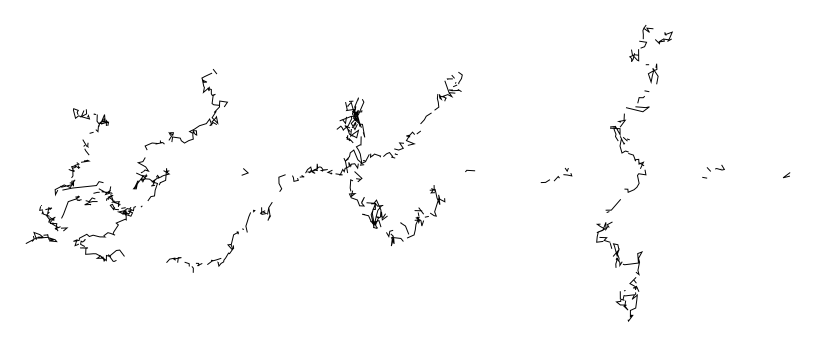

In [86]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

In [0]:

def get_model_params():
  # get trainable params.
  model_names = []
  model_params = []
  model_shapes = []
  with sess.as_default():
    t_vars = tf.trainable_variables()
    for var in t_vars:
      param_name = var.name
      p = sess.run(var)
      model_names.append(param_name)
      params = p
      model_params.append(params)
      model_shapes.append(p.shape)
  return model_params, model_shapes, model_names

def quantize_params(params, max_weight=10.0, factor=32767):
  result = []
  max_weight = np.abs(max_weight)
  for p in params:
    r = np.array(p)
    r /= max_weight
    r[r>1.0] = 1.0
    r[r<-1.0] = -1.0
    result.append(np.round(r*factor).flatten().astype(np.int).tolist())
  return result

In [0]:
model_params, model_shapes, model_names = get_model_params()

In [89]:
model_names

['vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/W_xh:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/W_hh:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_all/ln_gamma:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_all/ln_beta:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_c/ln_gamma:0',
 'vector_rnn/ENC_RNN/fw/LayerNormLSTMCell/ln_c/ln_beta:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/W_xh:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/W_hh:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_all/ln_gamma:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_all/ln_beta:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_c/ln_gamma:0',
 'vector_rnn/ENC_RNN/bw/LayerNormLSTMCell/ln_c/ln_beta:0',
 'vector_rnn/ENC_RNN_mu/super_linear_w:0',
 'vector_rnn/ENC_RNN_mu/super_linear_b:0',
 'vector_rnn/ENC_RNN_sigma/super_linear_w:0',
 'vector_rnn/ENC_RNN_sigma/super_linear_b:0',
 'vector_rnn/linear/super_linear_w:0',
 'vector_rnn/linear/super_linear_b:0',
 'vector_rnn/RNN/output_w:0',
 'vector_rnn/RNN/output_b:

In [0]:
# scale factor converts "model-coordinates" to "pixel coordinates" for your JS canvas demo later on.
# the larger it is, the larger your drawings (in pixel space) will be.
# I recommend setting this to 100.0 and iterating the value in the json file later on when you build the JS part.
scale_factor = 200.0
metainfo = {"mode":2,"version":6,"max_seq_len":train_set.max_seq_length,"name":"custom","scale_factor":scale_factor}

In [0]:
model_params_quantized = quantize_params(model_params)

In [0]:
model_blob = [metainfo, model_shapes, model_params_quantized]

In [0]:
with open("custom.gen.full.json", 'w') as outfile:
  json.dump(model_blob, outfile, separators=(',', ':'))

# OTHER STUFF!!!

In [0]:
download_pretrained_models(models_root_dir=models_root_dir)

In [0]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [0]:
data_set=['omniglot.npz']
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [0]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [0]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

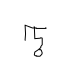

In [98]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

Let's try to encode the sample stroke into latent vector $z$

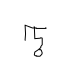

In [99]:
z = encode(stroke)

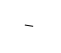

In [100]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

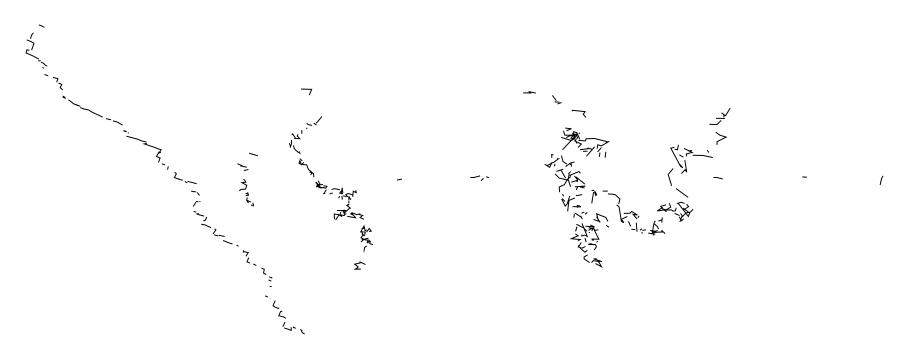

In [108]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

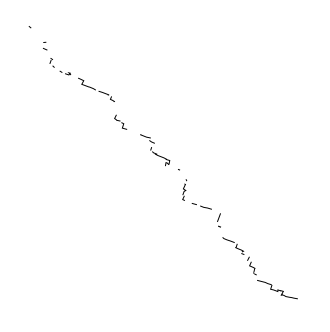

In [102]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

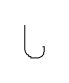

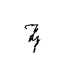

In [103]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [0]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [0]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

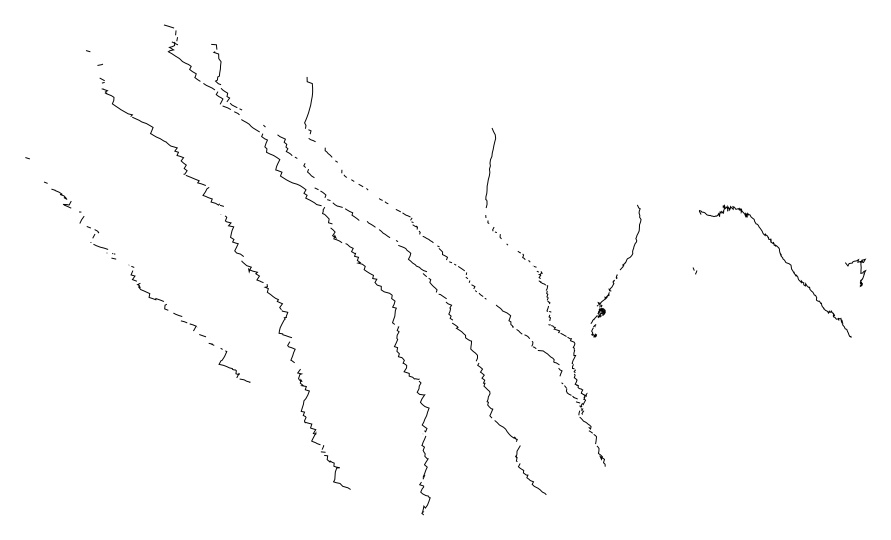

In [107]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [0]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [0]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [0]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [0]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [0]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [0]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [0]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [0]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [0]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

In [0]:
draw_strokes(stroke_grid, factor=0.3)